# 实战 Kaggle 比赛：狗的品种识别（ImageNet Dogs)# 

In [1]:
import os
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

In [2]:
#demo来选取数据集的一部分来进行实验

d2l.DATA_HUB['dog_tiny'] = (d2l.DATA_URL + 'kaggle_dog_tiny.zip',
                            '0cb91d09b814ecdc07b50f31f8dcad3e81d6a86d')

# 如果使用Kaggle比赛的完整数据集，请将下面的变量更改为False
demo = True
if demo:
    data_dir = d2l.download_extract('dog_tiny')
else:
    data_dir = os.path.join('..', 'data', 'dog-breed-identification')

In [3]:
#整理数据集 即从原始训练集中拆分验证集，然后将图像移动到按标签分组的子文件夹中。
def reorg_dog_data(data_dir, valid_ratio):
    labels = d2l.read_csv_labels(os.path.join(data_dir, 'labels.csv'))
    d2l.reorg_train_valid(data_dir, labels, valid_ratio)
    d2l.reorg_test(data_dir)
# d2l.reorg_train_valid 函数，
# 将数据集按照 valid_ratio 指定的比例拆分为训练集和验证集，
# 并将它们分别存放在相应的文件夹中。
# 例如，如果 valid_ratio 为 0.1，则 10% 的数据将被用作验证集。

batch_size = 32 if demo else 128
valid_ratio = 0.1
reorg_dog_data(data_dir, valid_ratio)

In [4]:
# 图片增广 对于训练集的图片处理 图片原来大小很大
transform_train = torchvision.transforms.Compose([
    # 随机裁剪图像，所得图像为原始面积的0.08～1之间，高宽比在3/4和4/3之间。
    # 然后，缩放图像以创建224x224的新图像
    torchvision.transforms.RandomResizedCrop(224, scale=(0.08, 1.0),
                                             ratio=(3.0/4.0, 4.0/3.0)),
    #以一定的概率随机水平翻转图像。
    torchvision.transforms.RandomHorizontalFlip(),
    # 随机更改亮度，对比度和饱和度
    torchvision.transforms.ColorJitter(brightness=0.4,
                                       contrast=0.4,
                                       saturation=0.4),
    # 添加随机噪声
    torchvision.transforms.ToTensor(),
    # 标准化图像的每个通道
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])])

In [5]:
# 图片增广 对于测试集的图片处理 图片原来大小很大
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    # 从图像中心裁切224x224大小的图片
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])])

In [6]:
#读取数据集
train_ds, train_valid_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_train) for folder in ['train', 'train_valid']]

# 训练集和训练验证集
valid_ds, test_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_test) for folder in ['valid', 'test']]

In [7]:
train_iter, train_valid_iter = [torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=True, drop_last=True)
    for dataset in (train_ds, train_valid_ds)]

valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False,
                                         drop_last=True)

test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False,
                                        drop_last=False)

In [8]:
#模型定义
def get_net(devices):
    # 创建一个顺序容器，用于定义网络结构
    finetune_net = nn.Sequential()
    # 使用预训练的 ResNet-34 作为特征提取器 ImageNet 数据集上预训练的权重。
    #True 这意味着模型的参数已经通过在 ImageNet 上的训练进行了调整，可以用于特征提取。
    finetune_net.features = torchvision.models.resnet34(pretrained=True)
    # 定义一个新的输出网络，共有120个输出类别
    # 定义一个新的输出层网络，
    #包含一个 1000 -> 256 的全连接层、ReLU 激活函数，以及一个 256 -> 120 的全连接层
    # 这里 120 是因为我们假设有 120 个类别（比如在狗品种分类任务中）
    finetune_net.output_new = nn.Sequential(nn.Linear(1000, 256),
                                            nn.ReLU(),
                                            nn.Linear(256, 120))
    # 将模型参数分配给用于计算的CPU或GPU
    finetune_net = finetune_net.to(devices[0])
    # 冻结特征提取器部分的参数，即不更新预训练 ResNet-34 的参数
    for param in finetune_net.features.parameters():
        param.requires_grad = False
    return finetune_net

In [9]:
loss = nn.CrossEntropyLoss(reduction='none')

In [15]:
# 用于评估模型在给定数据集上的平均损失
def evaluate_loss(data_iter, net, devices):
    l_sum, n = 0.0, 0  # 初始化损失总和和样本数量
    for features, labels in data_iter:  # 遍历数据迭代器中的每个批次
        features, labels = features.to(devices[0]), labels.to(devices[0])  # 将特征和标签移动到指定的设备（如 GPU）
        outputs = net(features)  # 通过模型计算输出
        l = loss(outputs, labels)  # 计算当前批次的损失
        l_sum += l.sum()  # 将当前批次的损失累加到损失总和
        n += labels.numel()  # 累加当前批次的样本数量
    return (l_sum / n).to('cpu')  # 返回平均损失，并将其移动到 CPU

In [16]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
          lr_decay):
    # 只训练小型自定义输出网络
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    trainer = torch.optim.SGD((param for param in net.parameters()
                               if param.requires_grad), lr=lr,
                              momentum=0.9, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss']
    if valid_iter is not None:
        legend.append('valid loss')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=legend)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(2)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            features, labels = features.to(devices[0]), labels.to(devices[0])
            trainer.zero_grad()
            output = net(features)
            l = loss(output, labels).sum()
            l.backward()
            trainer.step()
            metric.add(l, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[1], None))
        measures = f'train loss {metric[0] / metric[1]:.3f}'
        if valid_iter is not None:
            valid_loss = evaluate_loss(valid_iter, net, devices)
            animator.add(epoch + 1, (None, valid_loss.detach().cpu()))
        scheduler.step()
    if valid_iter is not None:
        measures += f', valid loss {valid_loss:.3f}'
    print(measures + f'\n{metric[1] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')

train loss 1.085, valid loss 1.474
651.9 examples/sec on [device(type='cuda', index=0)]


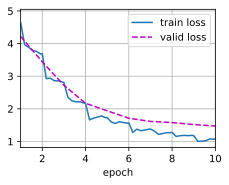

In [17]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 10, 1e-4, 1e-4
lr_period, lr_decay, net = 2, 0.9, get_net(devices)
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

train loss 1.060
516.6 examples/sec on [device(type='cuda', index=0)]


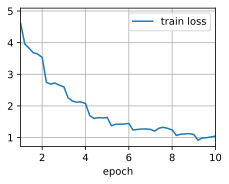

In [18]:
# 获取模型
net = get_net(devices)

# 训练模型
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period, lr_decay)

# 初始化预测列表
preds = []

# 遍历测试数据集
for data, label in test_iter:
    # 将数据移动到设备（如 GPU）上，
    # 并通过模型进行预测使用 softmax 函数将模型输出转换为概率分布。
    # 将预测结果移动到 CPU，转换为 NumPy 数组，并添加到 preds 列表中。
    output = torch.nn.functional.softmax(net(data.to(devices[0])), dim=1)
    # 将预测结果移动到 CPU 并转换为 NumPy 数组，添加到预测列表中
    preds.extend(output.cpu().detach().numpy())

# 获取测试集中的所有文件名，并按字母顺序排序
ids = sorted(os.listdir(os.path.join(data_dir, 'train_valid_test', 'test', 'unknown')))

# 打开一个新的文件 'submission.csv' 进行写入
with open('submission.csv', 'w') as f:
    # 写入 CSV 文件头，包含 id 和所有类别的名称
    f.write('id,' + ','.join(train_valid_ds.classes) + '\n')
    # 遍历测试集文件名和预测结果
    for i, output in zip(ids, preds):
        # 写入每个文件的预测结果
        f.write(i.split('.')[0] + ',' + ','.join([str(num) for num in output]) + '\n')

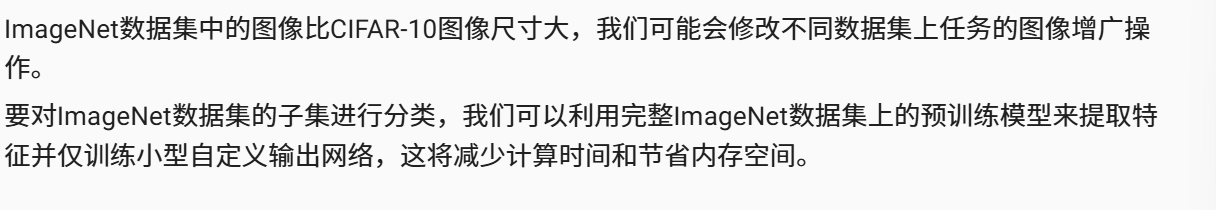